## Data generator example
---

Example showing how to create a PyTorch compatible generator which windows trace data and applies standard data augmentation steps. 

Data generation API also uses function-based decorators to allow user to easily construct data augmentation and processing pipelines. Example usage is also shown below.

***Current version of the data generator code is incomplete and subject to change**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('./', os.pardir)))

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import seisbench.data

Get dummy dataset:

In [2]:
dummy = seisbench.data.DummyDataset()
print(dummy)

dummydataset - 100 traces


Create training/label example generator object.

In [3]:
from seisbench.util.generate import PytorchWindowGenerator

pwg = PytorchWindowGenerator(
    dataset=dummy,
    windowlen=300,
    timestep=100,
    processing={'shuffle': True, 'normalize' : 'window'}
)

Simple PyTorch generator creates sequential windows of traces. Each iteration of the generator will window a trace using a pre-defined window length and timestep. Generator object inherits all functionality of a standard PyTorch Dataset so then can be wrapped in a DataLoader class adding standard multiprocessing worker, batch functionality etc.

In [4]:
# Wrap generator in PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=pwg, 
    batch_size=5, 
    pin_memory=True, 
    shuffle=False
)

Iterate through training data...

In [5]:
def compress_batch_dim(t):
    """
    Utility function to stack tensor data along batch dim.
    :param t: tensor, format (B, N, W, C)
    :type t: torch.Tensor
    :return : t: tensor, format (N, C, W)
    """
    return t.reshape(-1, t.shape[2], t.shape[3])


for X, y in train_loader:
    print('PyTorch DataLoader format:\n\t[B, N, C, W]\n')
    print('-->', X.shape)
    
    X = compress_batch_dim(X)
    print('\nCompressed windows along batch dim (now [N, C, W])\n')
    print('-->', X.shape)
    break

PyTorch DataLoader format:
	[B, N, C, W]

--> torch.Size([5, 9, 3, 300])

Compressed windows along batch dim (now [N, C, W])

--> torch.Size([45, 3, 300])


Plot all training examples (no processing applied to windowed traces)

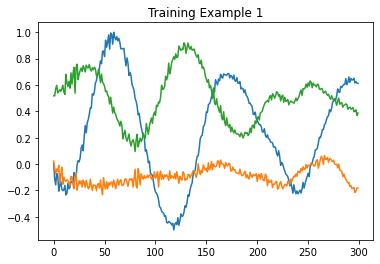

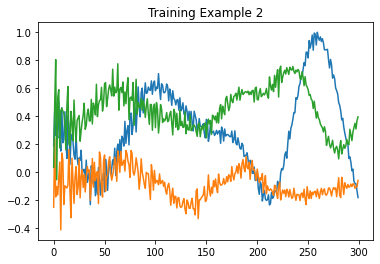

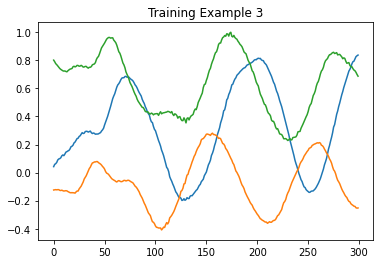

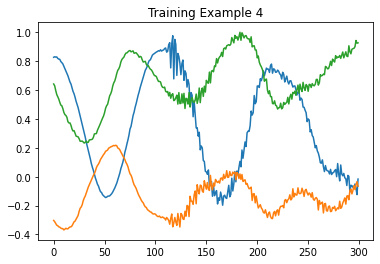

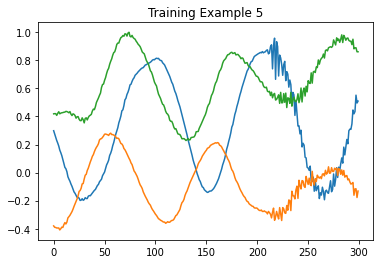

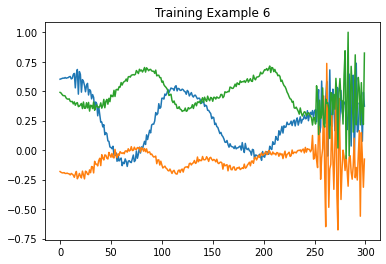

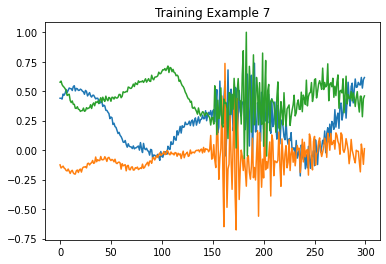

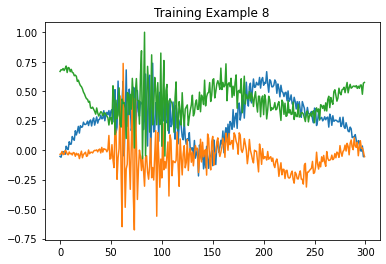

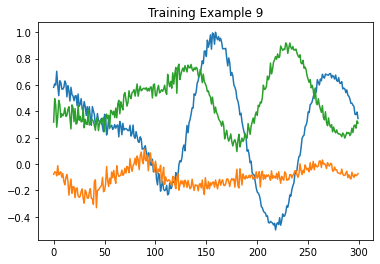

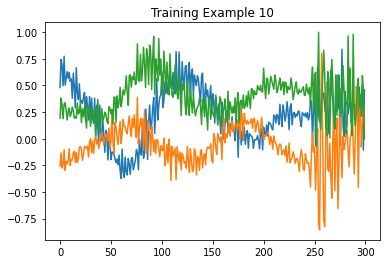

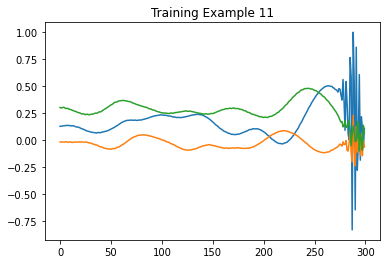

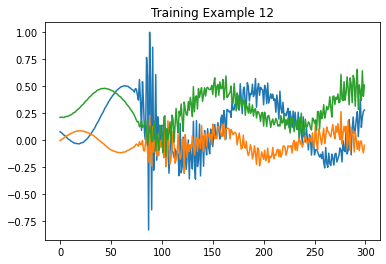

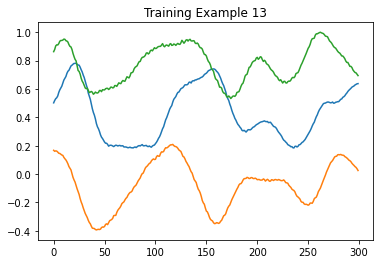

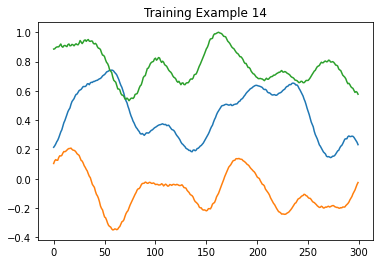

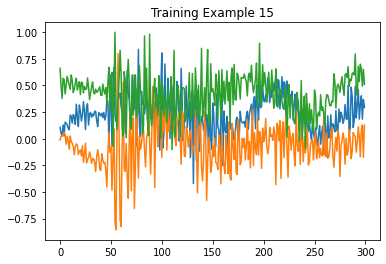

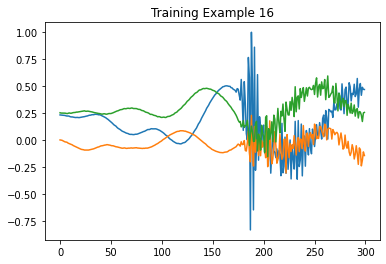

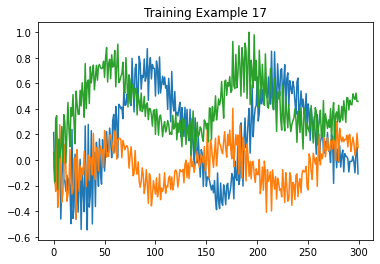

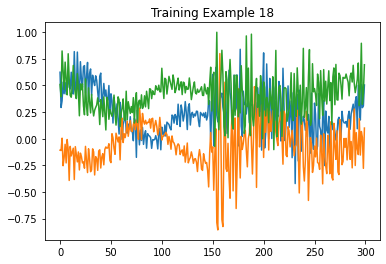

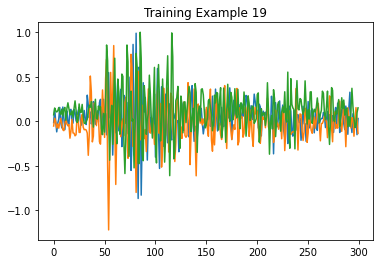

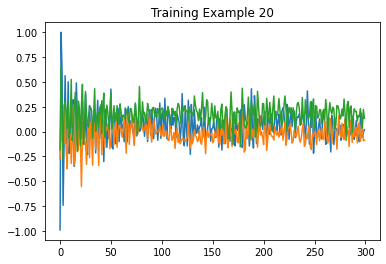

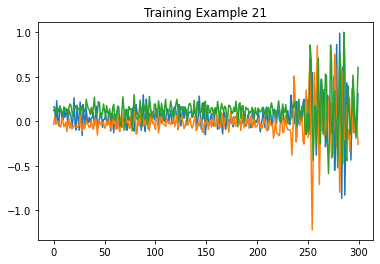

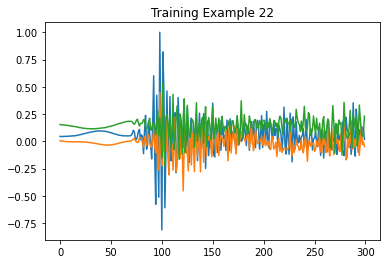

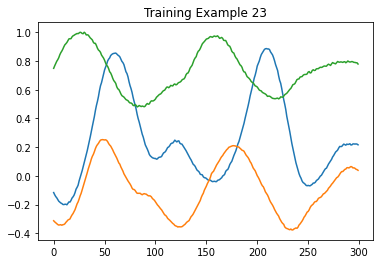

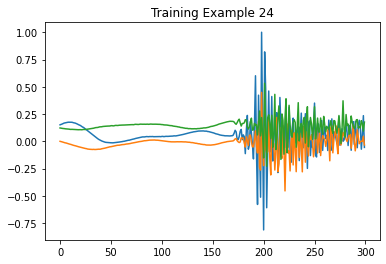

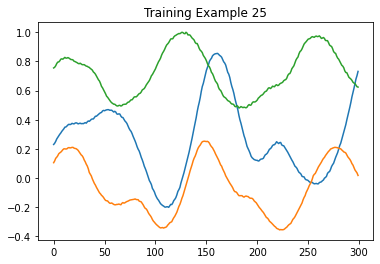

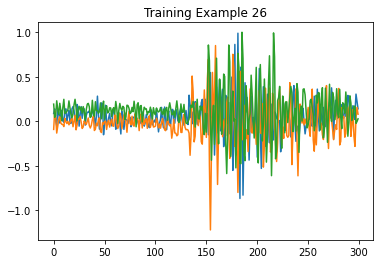

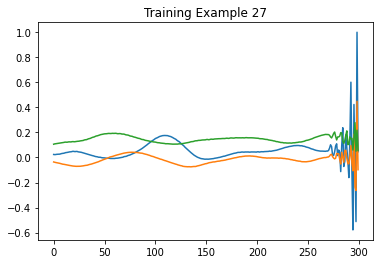

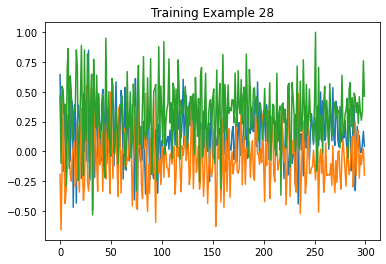

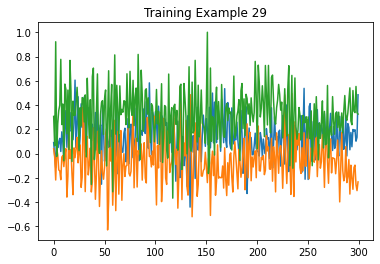

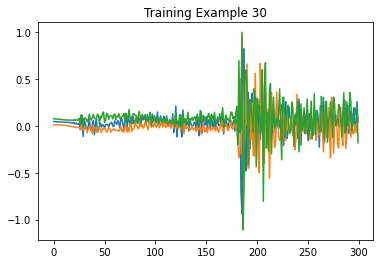

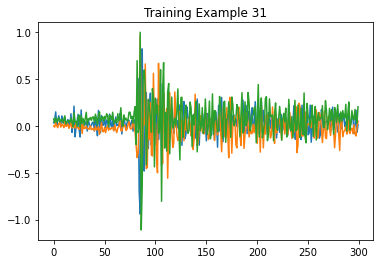

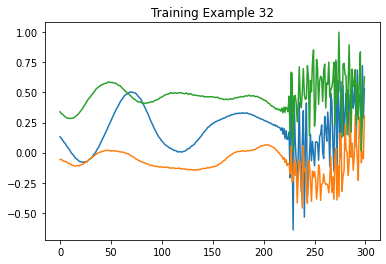

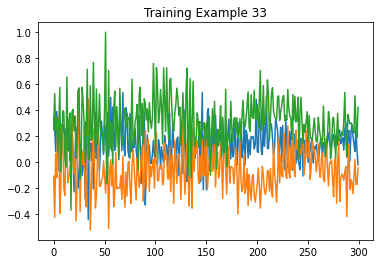

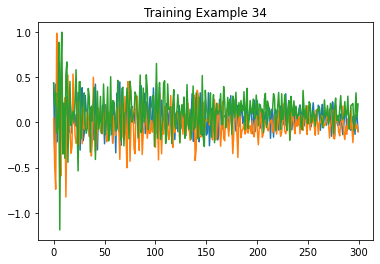

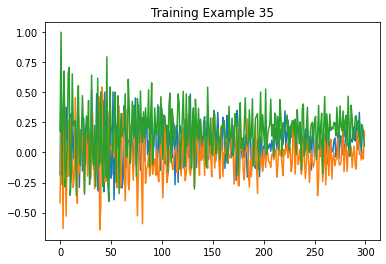

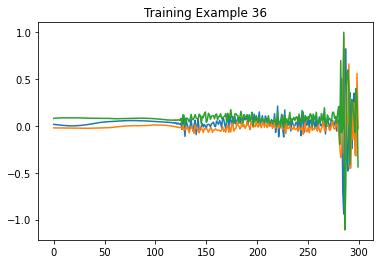

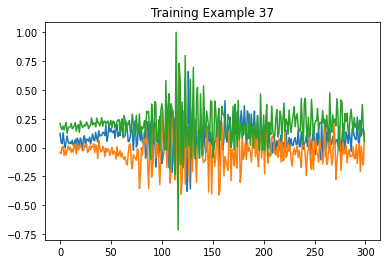

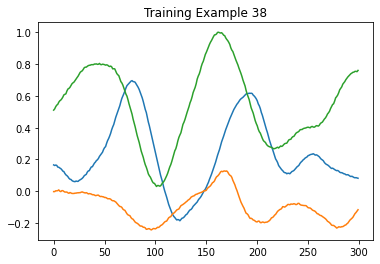

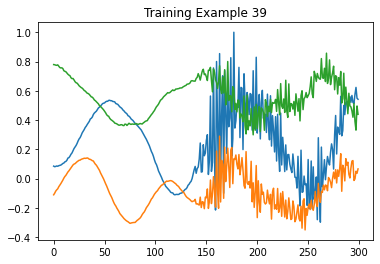

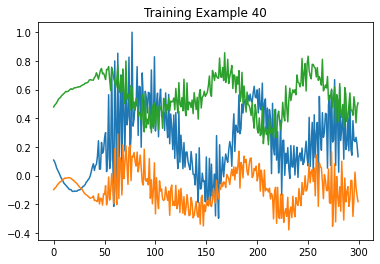

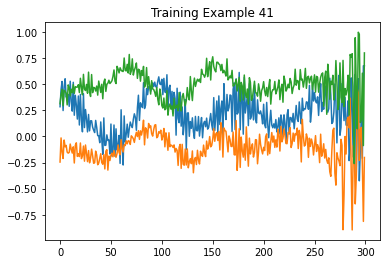

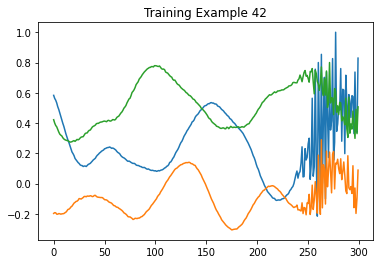

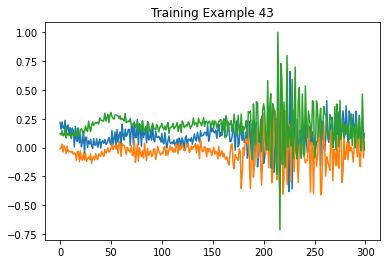

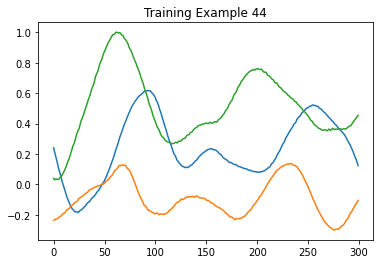

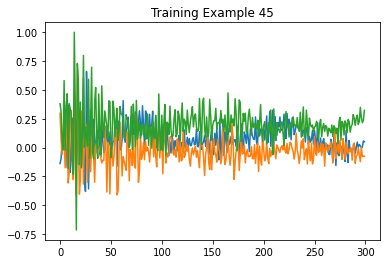

In [6]:
for i, window in enumerate(X):
    plt.title(f'Training Example {i+1}')
    plt.plot(window.T)
    plt.show()

## Introducing TrainingExample and SupervisedLabels
---

To enhance the potential usage within the seismological and ML community, a top-level abstract interface is introduced for both training data **(TrainingExample)** and labelling **(SupervisedLabel)**.

A **TrainingExample** object encourages the use of the function decorator syntax to easily construct data-augmentation pipelines. The object is initialised with some training data *X* and optional label data *y*. Processing steps to transform and modify the training data are then implemented through the use of custom functions. Each function defines how the training example (X) is to be modified. If the process also needs to be applied to the label data (for example when shuffling), the label data should also be included.

Because there aren't any pick labels in dummy dataset currently.. We use a simple supervised image classification data as an example. Also demonstrates the robustness of the API (not dependant upon a specific type of training data).

### Download supervised classfiication data with labels

In [7]:
from seisbench.util.generate import TrainingExample
import numpy as np

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./temp', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./temp', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Plot training examples with classes

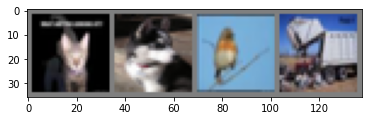

       cat        dog       bird      truck


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Use seisbench TrainingExample API to apply data augmentations

In [9]:
train = TrainingExample(X=images, y=labels)

train is now an object which holds the training and label data in its state. It will now track any processing steps applied; all users need to do is decorate their processing operations with the TrainingExample.augment method. 

*Again the only requirement is that any processing methods (such as shuffle and normalize below) has X as the first input argument - if y is to be included, that comes as the second input argument).*

First, apply shuffling to training example. As this needs to be performed on both training and label data, pass both as arguments to the function.

Second, apply window normalisation to the training example.

In [10]:
@train.augment
def shuffle(X, y):
    shuffle_idxs = [i for i in range(len(X))]
    np.random.shuffle(shuffle_idxs)
    X = np.array(X[shuffle_idxs], dtype=float)
    y = np.array(y[shuffle_idxs], dtype=float)
    return X, y

@train.augment
def window_normalize(X):
    X = np.array(
        [window / 5 for window in X], dtype=float
    )
    return X

Display the tracking of processing steps in the TrainingExample object state. Each processing function will be applied via the chronological order they were added to the TrainingExample object.

In [11]:
import pprint
print('Processing functions to apply:\n')
pprint.pprint(dict(train._processing), indent=1)

Processing functions to apply:

{'shuffle': {'args': (),
             'func': <function shuffle at 0x7ff476894830>,
             'include_y': True,
             'kwargs': {}},
 'window_normalize': {'args': (),
                      'func': <function window_normalize at 0x7ff448f4c170>,
                      'include_y': False,
                      'kwargs': {}}}


Show original training examples and labels

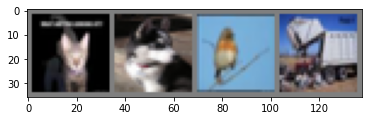

       cat        dog       bird      truck


In [12]:
imshow(torchvision.utils.make_grid(torch.Tensor(train.X)))
print(' '.join('%10s' % classes[int(train.y[j])] for j in range(4)))

Apply processing

In [13]:
train.apply_processing()

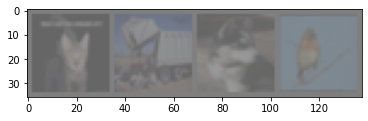

       cat      truck        dog       bird


In [14]:
imshow(torchvision.utils.make_grid(torch.Tensor(train.X)))
print(' '.join('%10s' % classes[int(train.y[j])] for j in range(4)))